In [5]:
# —— 公共头部：导入 + 公共函数定义 + 配置 ——
import os
import csv
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

# 请改为你本地的 chromedriver 路径
chrome_driver_path = "/usr/local/bin/chromedriver"

def load_and_rename(csv_path: str, kind: str):
    """
    读取 CSV 并重命名列为统一名称 area + price/rent。
    kind = "buy" 或 "rent"
    """
    df = pd.read_csv(csv_path, encoding="utf-8-sig")
    rename_map = {}
    for col in df.columns:
        if "面积" in col:
            rename_map[col] = "area"
    if kind == "rent":
        for col in df.columns:
            if "租" in col or "金" in col or "价格" in col:
                rename_map[col] = "rent"
    else:  # buy
        for col in df.columns:
            if "价" in col or "价格" in col:
                rename_map[col] = "price"
    df = df.rename(columns=rename_map)
    return df

def ensure_dir(file_path: str):
    """
    确保保存文件时目录存在
    """
    d = os.path.dirname(file_path)
    if d and not os.path.exists(d):
        os.makedirs(d)

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False


In [6]:
# —— 模块 1：爬取房价（buy）数据 ——
service = Service(chrome_driver_path)
options = webdriver.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=service, options=options)

url = "https://esf.fang.com/house-a012-b01183/"
driver.get(url)

wait = WebDriverWait(driver, 10)
page = 1
max_pages = 20
data_list = []

while page <= max_pages:
    print(f"爬取房价：第 {page} 页")
    try:
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "dl[dataflag='bg']")))
        houses = driver.find_elements(By.CSS_SELECTOR, "dl[dataflag='bg']")
        if not houses:
            print("无房源，退出")
            break
        for h in houses:
            try:
                info = h.find_element(By.CSS_SELECTOR, "p.tel_shop").text.strip()
                area_match = re.search(r"(\d+(?:\.\d+)?)㎡", info)
                area = area_match.group(1) if area_match else ""
                price_text = h.find_element(By.CSS_SELECTOR, "dd.price_right span.red b").text.strip()
                price_match = re.search(r"\d+", price_text)
                price = price_match.group(0) if price_match else ""
                if area and price:
                    data_list.append((price, area))
            except Exception:
                continue
        next_btn = driver.find_elements(By.LINK_TEXT, "下一页")
        if next_btn and page < max_pages:
            next_btn[0].click()
            page += 1
            time.sleep(2)
        else:
            break
    except Exception as e:
        print("异常：", e)
        break

driver.quit()

filename = "buy_tiantongyuan.csv"
ensure_dir(filename)
with open(filename, "w", newline="", encoding="utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerow(["价格", "面积"])
    writer.writerows(data_list)

print(f"已保存房价数据：{filename}，共 {len(data_list)} 条")


爬取房价：第 1 页
爬取房价：第 2 页
爬取房价：第 3 页
爬取房价：第 4 页
爬取房价：第 5 页
爬取房价：第 6 页
爬取房价：第 7 页
爬取房价：第 8 页
爬取房价：第 9 页
爬取房价：第 10 页
爬取房价：第 11 页
爬取房价：第 12 页
爬取房价：第 13 页
爬取房价：第 14 页
爬取房价：第 15 页
爬取房价：第 16 页
爬取房价：第 17 页
爬取房价：第 18 页
爬取房价：第 19 页
爬取房价：第 20 页
已保存房价数据：buy_tiantongyuan.csv，共 1200 条


In [7]:
# —— 模块 2：爬取租金（rent）数据 ——
service = Service(chrome_driver_path)
options = webdriver.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=service, options=options)

url = "https://zu.fang.com/house-a012-b01183/"
driver.get(url)

wait = WebDriverWait(driver, 10)
page = 1
max_pages = 20
rent_list = []

while page <= max_pages:
    print(f"爬取租金：第 {page} 页")
    try:
        wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "houseList")))
        houses = driver.find_elements(By.XPATH, '//dl[@class="list hiddenMap rel"]')
        if not houses:
            print("无租金房源，退出")
            break
        for h in houses:
            try:
                detail = h.find_element(By.CLASS_NAME, "font15.mt12.bold").text.strip()
                area_match = re.search(r"(\d+(?:\.\d+)?)㎡", detail)
                area = area_match.group(1) if area_match else ""
                price_text = h.find_element(By.CLASS_NAME, "price").text.strip()
                p_match = re.search(r"\d+", price_text)
                price = p_match.group(0) if p_match else ""
                if area and price:
                    rent_list.append((price, area))
            except Exception:
                continue
        next_btn = driver.find_elements(By.XPATH, '//a[text()="下一页"]')
        if next_btn and page < max_pages:
            next_btn[0].click()
            page += 1
            time.sleep(2)
        else:
            break
    except Exception as e:
        print("异常：", e)
        break

driver.quit()

filename = "rent_tiantongyuan.csv"
ensure_dir(filename)
with open(filename, "w", newline="", encoding="utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerow(["价格", "面积"])
    writer.writerows(rent_list)

print(f"已保存租金数据：{filename}，共 {len(rent_list)} 条")


爬取租金：第 1 页
爬取租金：第 2 页
爬取租金：第 3 页
爬取租金：第 4 页
爬取租金：第 5 页
爬取租金：第 6 页
爬取租金：第 7 页
爬取租金：第 8 页
爬取租金：第 9 页
爬取租金：第 10 页
爬取租金：第 11 页
爬取租金：第 12 页
爬取租金：第 13 页
爬取租金：第 14 页
爬取租金：第 15 页
爬取租金：第 16 页
爬取租金：第 17 页
爬取租金：第 18 页
爬取租金：第 19 页
爬取租金：第 20 页
已保存租金数据：rent_tiantongyuan.csv，共 1200 条


各区中位数指标：
         region     med_price   med_rent  price_rent_ratio
0   huilongguan  39117.958012  74.712644        523.578823
1       huoying  40948.132366  73.170732        559.624476
2  tiantongyuan  31630.025505  63.725490        496.348093
3         shahe  46931.616627  50.000000        938.632333


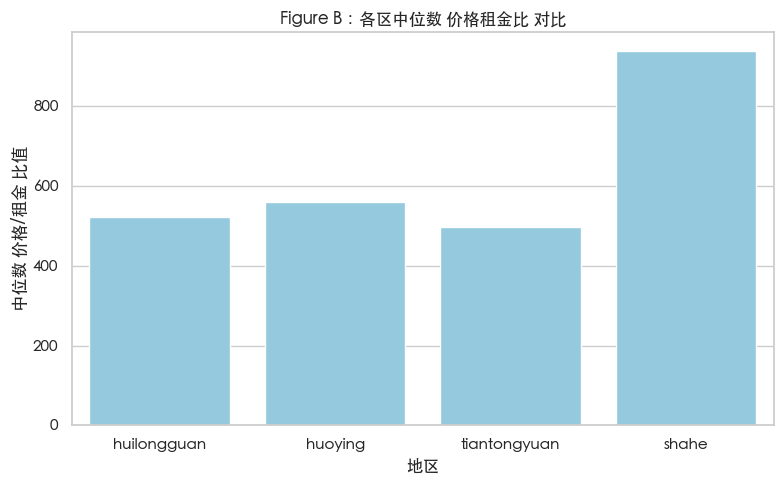

In [8]:
# —— 模块 3：统计 + 各区中位数比值 + 绘图 ——
regions = ["huilongguan", "huoying", "tiantongyuan", "shahe"]
records = []

for reg in regions:
    bf = f"buy_{reg}.csv"
    rf = f"rent_{reg}.csv"
    if os.path.exists(bf) and os.path.exists(rf):
        bd = load_and_rename(bf, kind="buy")
        rd = load_and_rename(rf, kind="rent")
        bd = bd[bd["area"] > 0].copy()
        rd = rd[rd["area"] > 0].copy()
        bd["price_yuan_per_m2"] = (bd["price"] / bd["area"]) * 10000
        rd["rent_yuan_per_m2"] = rd["rent"] / rd["area"]
        mp = bd["price_yuan_per_m2"].median()
        mr = rd["rent_yuan_per_m2"].median()
        ratio = mp / mr if (mr and mr > 0) else None
    else:
        mp, mr, ratio = None, None, None
    records.append({
        "region": reg,
        "med_price": mp,
        "med_rent": mr,
        "price_rent_ratio": ratio
    })

dfm = pd.DataFrame(records)
print("各区中位数指标：")
print(dfm)

plt.figure(figsize=(8,5))
sns.barplot(x="region", y="price_rent_ratio", data=dfm, color="skyblue")
plt.xlabel("地区")
plt.ylabel("中位数 价格/租金 比值")
plt.title("Figure B：各区中位数 价格租金比 对比")
plt.tight_layout()
plt.show()


预测结果已保存为 model_predictions.csv
=== 性能指标 ===
房价模型：R² = 0.3637, MSE = 207130316.7657
租金模型：R² = 0.1438, MSE = 855.8092


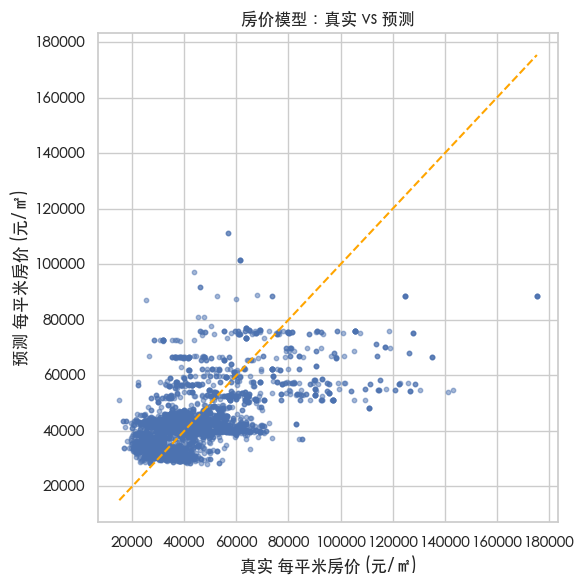

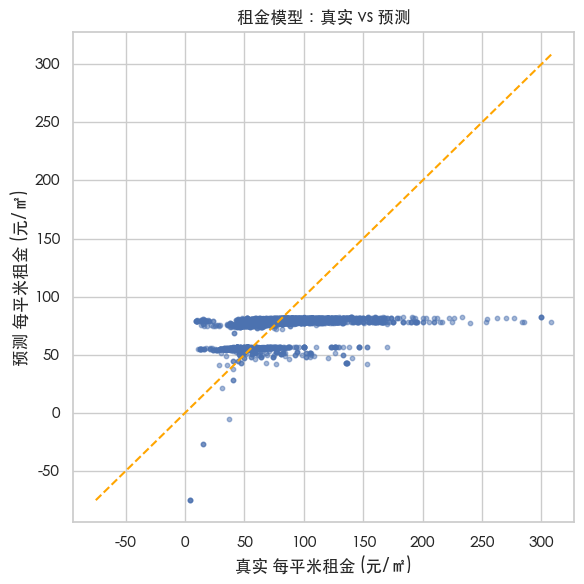

In [11]:
# —— 模块 4：线性回归 + 预测 + 指标 + 输出 + 图像 ——
def build_models_and_plot(all_buy: pd.DataFrame, all_rent: pd.DataFrame, merged_output_csv="model_predictions.csv"):
    enc = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
    re_enc = enc.fit_transform(all_buy[["region"]])
    feat_names = enc.get_feature_names_out(["region"])
    Xp = pd.DataFrame(re_enc, columns=feat_names, index=all_buy.index)
    Xp["area"] = all_buy["area"]
    y_price = all_buy["price_yuan_per_m2"]
    model_p = LinearRegression()
    model_p.fit(Xp, y_price)
    y_p_pred = model_p.predict(Xp)

    Xr = pd.DataFrame(enc.transform(all_rent[["region"]]), columns=feat_names, index=all_rent.index)
    Xr["area"] = all_rent["area"]
    y_rent = all_rent["rent_yuan_per_m2"]
    model_r = LinearRegression()
    model_r.fit(Xr, y_rent)
    y_r_pred = model_r.predict(Xr)

    # 保存预测结果
    all_buy["pred_price_yuan_per_m2"] = y_p_pred
    all_rent["pred_rent_yuan_per_m2"] = y_r_pred
    merged = pd.merge(all_buy, all_rent, on=["area", "region"], how="inner", suffixes=("_buy", "_rent"))
    merged["pred_price_rent_ratio"] = merged["pred_price_yuan_per_m2"] / merged["pred_rent_yuan_per_m2"]
    merged.to_csv(merged_output_csv, index=False, encoding="utf-8-sig")
    print(f"预测结果已保存为 {merged_output_csv}")

    # 计算性能指标
    r2_p = r2_score(y_price, y_p_pred)
    mse_p = mean_squared_error(y_price, y_p_pred)
    r2_r = r2_score(y_rent, y_r_pred)
    mse_r = mean_squared_error(y_rent, y_r_pred)
    print("=== 性能指标 ===")
    print(f"房价模型：R² = {r2_p:.4f}, MSE = {mse_p:.4f}")
    print(f"租金模型：R² = {r2_r:.4f}, MSE = {mse_r:.4f}")

    sns.set(style="whitegrid")
    plt.rcParams["font.family"] = ["Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False

    # 房价：真实 vs 预测 散点 + 参考线
    plt.figure(figsize=(6,6))
    plt.scatter(y_price, y_p_pred, alpha=0.5, s=10)
    mn = min(y_price.min(), y_p_pred.min())
    mx = max(y_price.max(), y_p_pred.max())
    plt.plot([mn, mx], [mn, mx], "orange", linestyle="--")
    plt.xlabel("真实 每平米房价 (元/㎡)")
    plt.ylabel("预测 每平米房价 (元/㎡)")
    plt.title("房价模型：真实 vs 预测")
    plt.tight_layout()
    plt.show()

    # 租金：真实 vs 预测 散点 + 参考线
    plt.figure(figsize=(6,6))
    plt.scatter(y_rent, y_r_pred, alpha=0.5, s=10)
    mn2 = min(y_rent.min(), y_r_pred.min())
    mx2 = max(y_rent.max(), y_r_pred.max())
    plt.plot([mn2, mx2], [mn2, mx2], "orange", linestyle="--")
    plt.xlabel("真实 每平米租金 (元/㎡)")
    plt.ylabel("预测 每平米租金 (元/㎡)")
    plt.title("租金模型：真实 vs 预测")
    plt.tight_layout()
    plt.show()

    return model_p, model_r

# —— 主流程：合并多地区数据调用模型 ——
regions = ["huilongguan", "huoying", "tiantongyuan", "shahe"]
buy_list, rent_list = [], []
for reg in regions:
    bf = f"buy_{reg}.csv"
    rf = f"rent_{reg}.csv"
    if os.path.exists(bf) and os.path.exists(rf):
        bd = load_and_rename(bf, kind="buy")
        rd = load_and_rename(rf, kind="rent")
        bd["region"] = reg
        rd["region"] = reg
        bd["price_yuan_per_m2"] = (bd["price"] / bd["area"]) * 10000
        rd["rent_yuan_per_m2"] = rd["rent"] / rd["area"]
        buy_list.append(bd[["area","region","price_yuan_per_m2"]])
        rent_list.append(rd[["area","region","rent_yuan_per_m2"]])

if buy_list and rent_list:
    all_buy = pd.concat(buy_list, ignore_index=True)
    all_rent = pd.concat(rent_list, ignore_index=True)
    _ = build_models_and_plot(all_buy, all_rent)
else:
    print("无足够数据建模")


升级预测结果保存为 model_plus.csv
=== 升级模型性能指标 ===
房价 Base: R²=0.3637, MSE=207130316.7657
房价 Plus: R²=0.3968, MSE=196362955.8586
租金 Base: R²=0.1438, MSE=855.8092
租金 Plus: R²=0.4567, MSE=543.0424


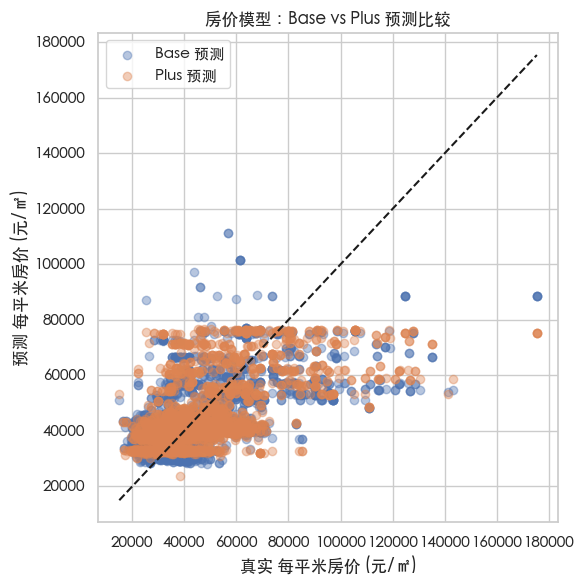

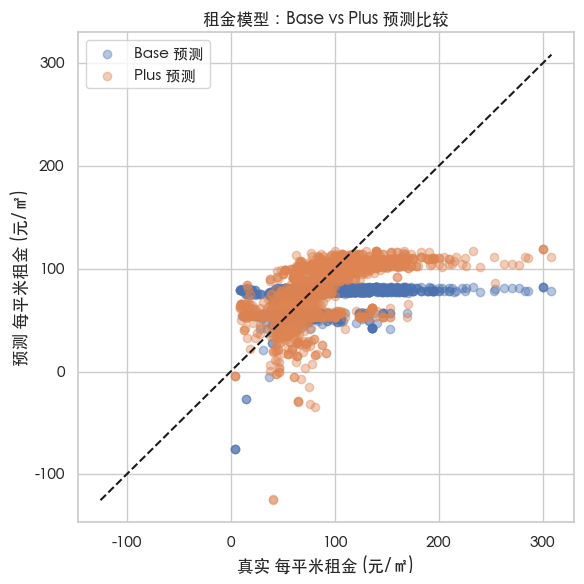

In [12]:
 # —— 模块 5：模型升级 + 性能指标 + 对比图 ——
def build_upgrade(all_buy: pd.DataFrame, all_rent: pd.DataFrame, output_csv="model_plus.csv"):
    enc = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
    re_enc = enc.fit_transform(all_buy[["region"]])
    fnames = enc.get_feature_names_out(["region"])
    Xb_price = pd.DataFrame(re_enc, columns=fnames, index=all_buy.index)
    Xb_price["area"] = all_buy["area"]
    y_p = all_buy["price_yuan_per_m2"]

    Xb_rent = pd.DataFrame(enc.transform(all_rent[["region"]]), columns=fnames, index=all_rent.index)
    Xb_rent["area"] = all_rent["area"]
    y_r = all_rent["rent_yuan_per_m2"]

    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    Xp = poly.fit_transform(Xb_price)
    Xr = poly.transform(Xb_rent)

    # 基础模型
    model_b_p = LinearRegression()
    model_b_p.fit(Xb_price, y_p)
    pred_b_p = model_b_p.predict(Xb_price)

    model_b_r = LinearRegression()
    model_b_r.fit(Xb_rent, y_r)
    pred_b_r = model_b_r.predict(Xb_rent)

    # 升级模型
    model_p_p = LinearRegression()
    model_p_p.fit(Xp, y_p)
    pred_p_p = model_p_p.predict(Xp)

    model_p_r = LinearRegression()
    model_p_r.fit(Xr, y_r)
    pred_p_r = model_p_r.predict(Xr)

    # 保存预测结果
    all_buy["base_pred_price"] = pred_b_p
    all_buy["plus_pred_price"] = pred_p_p
    all_rent["base_pred_rent"] = pred_b_r
    all_rent["plus_pred_rent"] = pred_p_r

    merged = pd.merge(all_buy, all_rent, on=["area", "region"], how="inner", suffixes=("_b","_r"))
    merged["ratio_base"] = merged["base_pred_price"] / merged["base_pred_rent"]
    merged["ratio_plus"] = merged["plus_pred_price"] / merged["plus_pred_rent"]
    merged.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"升级预测结果保存为 {output_csv}")

    # 性能指标计算
    r2_b_p = r2_score(y_p, pred_b_p)
    mse_b_p = mean_squared_error(y_p, pred_b_p)
    r2_p_p = r2_score(y_p, pred_p_p)
    mse_p_p = mean_squared_error(y_p, pred_p_p)

    r2_b_r = r2_score(y_r, pred_b_r)
    mse_b_r = mean_squared_error(y_r, pred_b_r)
    r2_p_r = r2_score(y_r, pred_p_r)
    mse_p_r = mean_squared_error(y_r, pred_p_r)

    print("=== 升级模型性能指标 ===")
    print(f"房价 Base: R²={r2_b_p:.4f}, MSE={mse_b_p:.4f}")
    print(f"房价 Plus: R²={r2_p_p:.4f}, MSE={mse_p_p:.4f}")
    print(f"租金 Base: R²={r2_b_r:.4f}, MSE={mse_b_r:.4f}")
    print(f"租金 Plus: R²={r2_p_r:.4f}, MSE={mse_p_r:.4f}")

    sns.set(style="whitegrid")
    plt.rcParams["font.family"] = ["Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False

    # 房价对比图：真实 vs Base / Plus
    plt.figure(figsize=(6,6))
    plt.scatter(all_buy["price_yuan_per_m2"], pred_b_p, alpha=0.4, label="Base 预测")
    plt.scatter(all_buy["price_yuan_per_m2"], pred_p_p, alpha=0.4, label="Plus 预测")
    mn = min(all_buy["price_yuan_per_m2"].min(), pred_b_p.min(), pred_p_p.min())
    mx = max(all_buy["price_yuan_per_m2"].max(), pred_b_p.max(), pred_p_p.max())
    plt.plot([mn, mx], [mn, mx], "k--")
    plt.xlabel("真实 每平米房价 (元/㎡)")
    plt.ylabel("预测 每平米房价 (元/㎡)")
    plt.title("房价模型：Base vs Plus 预测比较")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 租金对比图
    plt.figure(figsize=(6,6))
    plt.scatter(all_rent["rent_yuan_per_m2"], pred_b_r, alpha=0.4, label="Base 预测")
    plt.scatter(all_rent["rent_yuan_per_m2"], pred_p_r, alpha=0.4, label="Plus 预测")
    mn2 = min(all_rent["rent_yuan_per_m2"].min(), pred_b_r.min(), pred_p_r.min())
    mx2 = max(all_rent["rent_yuan_per_m2"].max(), pred_b_r.max(), pred_p_r.max())
    plt.plot([mn2, mx2], [mn2, mx2], "k--")
    plt.xlabel("真实 每平米租金 (元/㎡)")
    plt.ylabel("预测 每平米租金 (元/㎡)")
    plt.title("租金模型：Base vs Plus 预测比较")
    plt.legend()
    plt.tight_layout()
    plt.show()

# —— 主流程 for 多区调用升级模型 ——
regions = ["huilongguan", "huoying", "tiantongyuan", "shahe"]
buy_list, rent_list = [], []
for reg in regions:
    bf = f"buy_{reg}.csv"
    rf = f"rent_{reg}.csv"
    if os.path.exists(bf) and os.path.exists(rf):
        bd = load_and_rename(bf, kind="buy")
        rd = load_and_rename(rf, kind="rent")
        bd["region"] = reg
        rd["region"] = reg
        bd["price_yuan_per_m2"] = (bd["price"] / bd["area"]) * 10000
        rd["rent_yuan_per_m2"] = rd["rent"] / rd["area"]
        buy_list.append(bd[["area","region","price_yuan_per_m2"]])
        rent_list.append(rd[["area","region","rent_yuan_per_m2"]])

if buy_list and rent_list:
    all_b = pd.concat(buy_list, ignore_index=True)
    all_r = pd.concat(rent_list, ignore_index=True)
    build_upgrade(all_b, all_r)
else:
    print("无足够数据进行升级建模")
